# Cluster Analysis - PySpark Example

## SDSC Summer Institute

## Set up environment

In [1]:
# Import modules

import pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline


In [2]:
# Start Spark session

from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),
                                   ('spark.app.name', 'PySpark Cluster Analysis')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version)
print (pyspark.version)

2.4.0
<module 'pyspark.version' from '/share/apps/compute/spark/spark-2.4.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/version.py'>


## Read in data

In [3]:
# Load minute weather data

inputfile = "minute_weather.csv"
df = spark.read.csv (inputfile, inferSchema=True, header=True).cache()

## Explore data

In [4]:
# Examine schema

df.printSchema()

root
 |-- rowID: integer (nullable = true)
 |-- hpwren_timestamp: timestamp (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- max_wind_direction: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- min_wind_direction: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- rain_accumulation: double (nullable = true)
 |-- rain_duration: double (nullable = true)
 |-- relative_humidity: double (nullable = true)



In [5]:
# Count rows

df.count()

1587257

In [6]:
# Filter rows 

filteredDF = df.filter((df.rowID % 100) == 0)
filteredDF.count()

15873

In [7]:
# Show summary statistics

filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,15873,793600.0,458228.4746717515,0,1587200
air_pressure,15873,916.8291627291621,3.0517222151795838,905.1,929.4
air_temp,15873,61.85468909468912,11.835413790821478,32.36,96.44
avg_wind_direction,15870,161.2875236294896,95.31316129656487,0.0,359.0
avg_wind_speed,15870,2.7928040327662256,2.070506198460019,0.1,20.1
max_wind_direction,15870,162.70094517958412,92.2696011266316,0.0,359.0
max_wind_speed,15870,3.4146250787649657,2.428906406812135,0.1,20.9
min_wind_direction,15870,166.64429741650915,97.82483630682512,0.0,359.0
min_wind_speed,15870,2.15226843100189,1.7581135042599592,0.0,19.5


## Prepare data

In [8]:
# Drop null data

workingDF = filteredDF.na.drop()
workingDF.count()

15869

In [9]:
# Create feature vector

featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [10]:
assembled.show(1)

+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+
|rowID|   hpwren_timestamp|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|rain_accumulation|rain_duration|relative_humidity|   features_unscaled|
+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+
|  100|2011-09-10 01:40:49|       911.8|   62.96|              95.0|           2.3|             106.0|           2.5|              88.0|           1.9|              0.0|          0.0|             63.9|[911.8,62.96,95.0...|
+-----+-------------------+------------+--------+------------------+--------------+------------------+------

In [11]:
# Scale data

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [12]:
scaledData.show(1)

+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+--------------------+
|rowID|   hpwren_timestamp|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|rain_accumulation|rain_duration|relative_humidity|   features_unscaled|            features|
+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+--------------------+
|  100|2011-09-10 01:40:49|       911.8|   62.96|              95.0|           2.3|             106.0|           2.5|              88.0|           1.9|              0.0|          0.0|             63.9|[911.8,62.96,95.0...|[-1.6482626429130...|
+-----+-----------------

## Perform cluster analysis

In [13]:
# Use one-third data for elbow plot

scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()
elbowset.count()

5289

In [14]:
# Generate clusters for elbow plot

clusters = range(5,15)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 5 
......................WSSE = 9147.432309558455 
Training for cluster size 6 
......................WSSE = 8445.863736404332 
Training for cluster size 7 
......................WSSE = 8170.674504518151 
Training for cluster size 8 
......................WSSE = 7846.6223844872275 
Training for cluster size 9 
......................WSSE = 7570.878097883046 
Training for cluster size 10 
......................WSSE = 7446.715915271796 
Training for cluster size 11 
......................WSSE = 7158.68828851007 
Training for cluster size 12 
......................WSSE = 7036.24531343363 
Training for cluster size 13 
......................WSSE = 6948.197555854832 
Training for cluster size 14 
......................WSSE = 6844.922582579276 


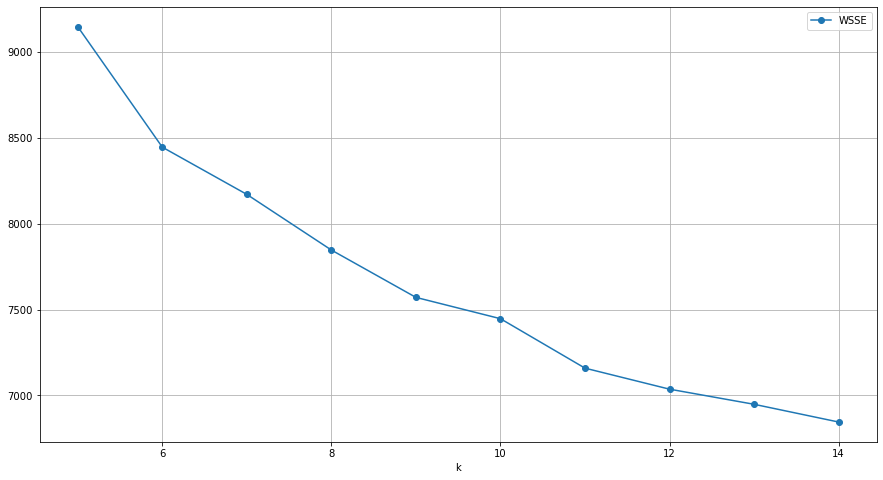

In [15]:
# Show elbow plot

utils.elbow_plot(wsseList, clusters)

In [16]:
# Run KMeans for k = 9

scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

kmeans = KMeans(k=9, seed=1)
model = kmeans.fit(scaledDataFeat)

In [17]:
# Extract cluster centers

centers = model.clusterCenters()
centers

[array([-0.23712775,  0.6060522 ,  0.42882583,  0.60949697,  0.51439165,
         0.55707757, -0.16689849]),
 array([-0.17371642,  0.85778983, -1.29030546, -0.57430275, -1.14972473,
        -0.58667657, -0.63108232]),
 array([ 0.30225119,  0.69244347,  1.3106006 , -0.65874505,  1.59489594,
        -0.6138022 , -0.65469236]),
 array([ 1.1866344 , -0.26045997, -1.13973189,  2.12635217, -1.04194893,
         2.24240715, -1.12864772]),
 array([-0.11003208,  0.62156931,  0.5220466 , -0.66506804,  0.00873596,
        -0.66466709, -0.47759661]),
 array([ 0.03301148, -0.75328396, -1.16113382, -0.58033538, -1.00757311,
        -0.5901304 ,  0.8624484 ]),
 array([ 1.41914978, -0.10287788, -1.07403376, -0.13439721, -0.96329376,
        -0.1160864 , -0.97276011]),
 array([-0.20600491, -1.07303367,  0.58495133, -0.25518762,  0.56054417,
        -0.25040616,  1.25059432]),
 array([-1.13765825, -0.9661163 ,  0.43956712,  1.6955892 ,  0.53465825,
         1.66723618,  1.02192546])]

## Generate cluster profile plots

In [18]:
centersNamed = utils.pd_centers(featuresUsed,centers)
print(centersNamed.columns.values)
print(centersNamed.shape)

['air_pressure' 'air_temp' 'avg_wind_direction' 'avg_wind_speed'
 'max_wind_direction' 'max_wind_speed' 'relative_humidity' 'prediction']
(9, 8)


### Profiles for All Clusters

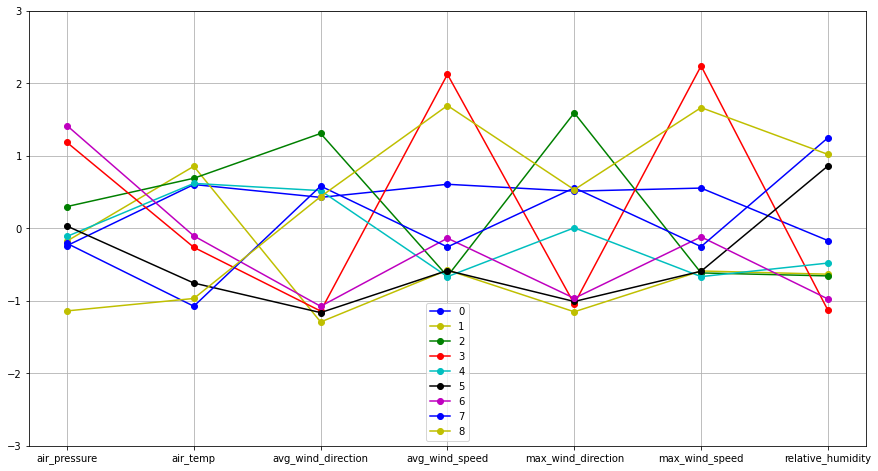

In [19]:
numClusters = len(centersNamed.index)
colors_used = utils.parallel_plot(centersNamed, numClusters)

### Clusters Capturing Dry Days

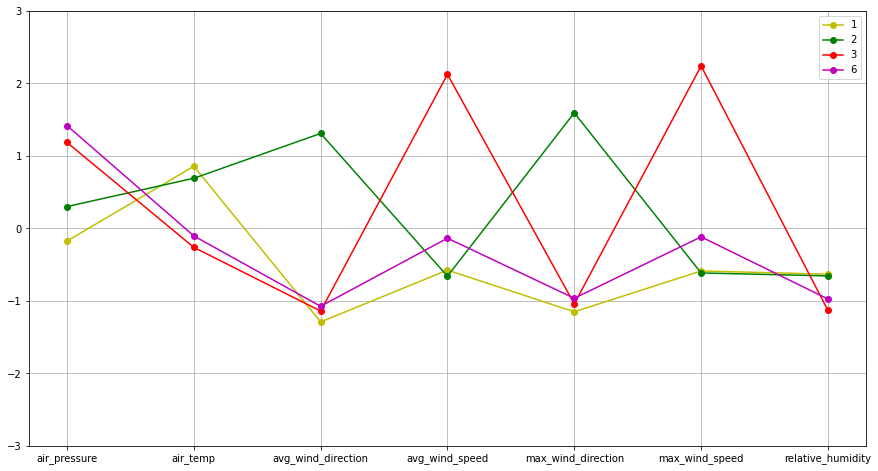

In [20]:
utils.parallel_plot(centersNamed[centersNamed['relative_humidity'] < -0.5], 
                   numClusters, colors=colors_used);

### Clusters Capturing Humid Days

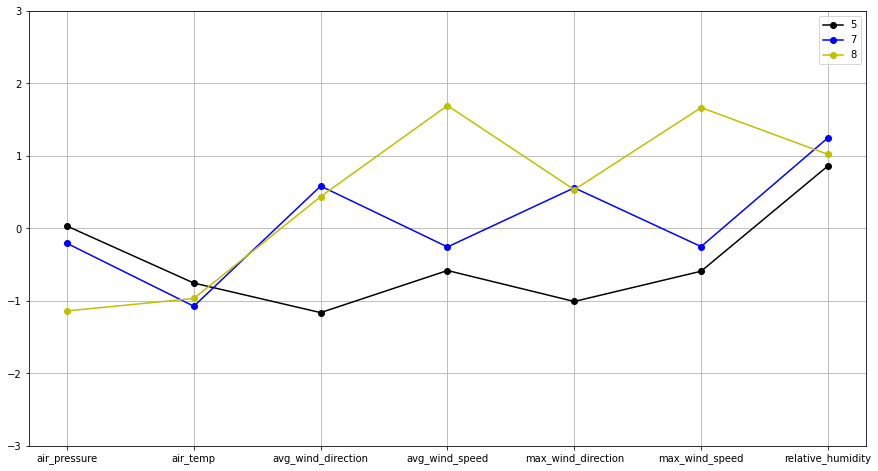

In [21]:
utils.parallel_plot(centersNamed[centersNamed['relative_humidity'] > 0.5], 
                    numClusters, colors=colors_used);

### Clusters Capturing Hot Days

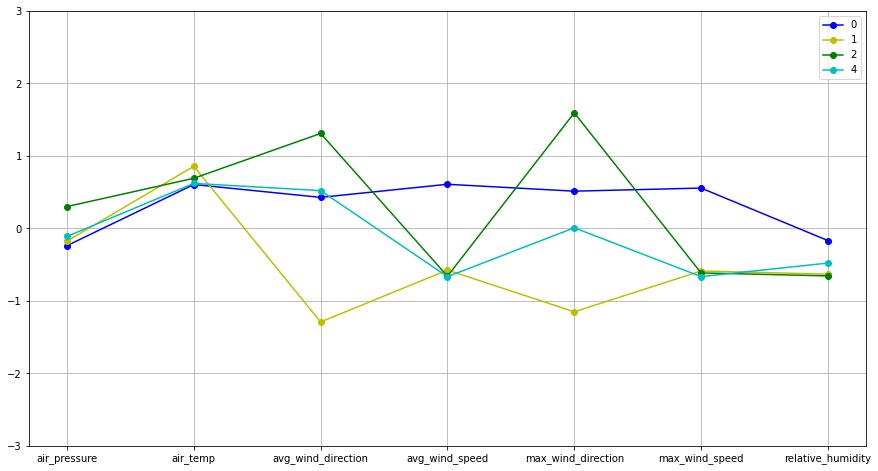

In [22]:
utils.parallel_plot(centersNamed[centersNamed['air_temp'] > 0.5], 
                   numClusters, colors=colors_used);

### Clusters Capturing Windy Days

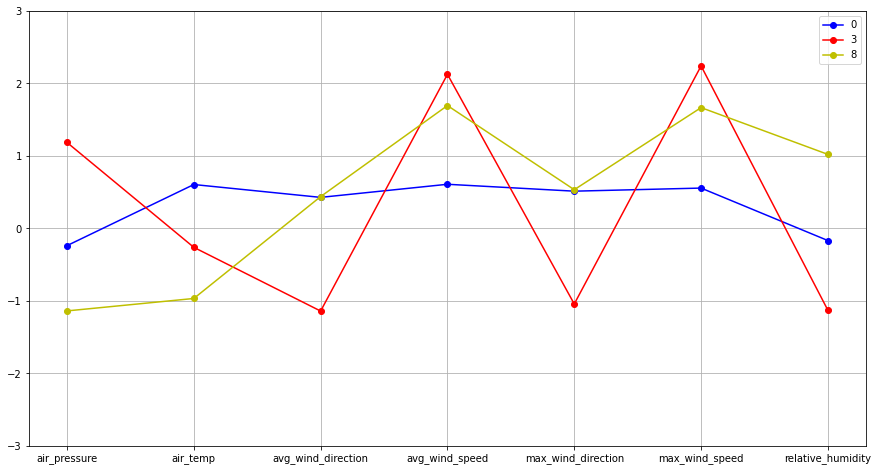

In [23]:
utils.parallel_plot(centersNamed[centersNamed['avg_wind_speed'] > 0.5], 
                   numClusters, colors=colors_used);

## Stop Spark session

In [24]:
spark.stop()